In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np 
from tqdm import tqdm
import optuna
from sklearn.preprocessing import  LabelEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import re
import xgboost as xgb
import lightgbm as lgb
import warnings 
from optuna.integration import XGBoostPruningCallback
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


# 불필요 특성 제거
transaction_id : 인덱스 번호 \
apartment_id : 아파트 ID \
jibun : 지번 \
addr_kr : 주소 \
transaction_date : 거래날짜(일 단위)

In [4]:
train= train.drop(['transaction_id','apartment_id',
                   'jibun', 'addr_kr','transaction_date',], axis=1)
test= test.drop(['transaction_id','apartment_id',
                 'jibun', 'addr_kr','transaction_date'], axis=1)

In [5]:
train.head()

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
0,서울특별시,신교동,신현(101동),84.82,2002,200801,2,37500
1,서울특별시,필운동,사직파크맨션,99.17,1973,200801,6,20000
2,서울특별시,필운동,두레엘리시안,84.74,2007,200801,6,38500
3,서울특별시,내수동,파크팰리스,146.39,2003,200801,15,118000
4,서울특별시,내수동,킹스매너,194.43,2004,200801,3,120000


# train, test 데이터 확인
df.describe() \
df.info()

In [6]:
train.describe() 

,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [7]:
test.describe()

,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5463.000000,5463.000000,5463.000000,5463.000000
mean,79.495250,2000.431082,201710.228446,8.266886
std,32.935434,9.982040,2.798195,6.082475
min,10.321500,1961.000000,201701.000000,-1.000000
25%,59.760000,1995.000000,201709.000000,4.000000
50%,81.720000,2002.000000,201712.000000,7.000000
75%,84.970000,2007.000000,201712.000000,11.000000
max,273.860000,2017.000000,201712.000000,55.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  object 
 1   dong                    1216553 non-null  object 
 2   apt                     1216553 non-null  object 
 3   exclusive_use_area      1216553 non-null  float64
 4   year_of_completion      1216553 non-null  int64  
 5   transaction_year_month  1216553 non-null  int64  
 6   floor                   1216553 non-null  int64  
 7   transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 74.3+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    5463 non-null   object 
 1   dong                    5463 non-null   object 
 2   apt                     5463 non-null   object 
 3   exclusive_use_area      5463 non-null   float64
 4   year_of_completion      5463 non-null   int64  
 5   transaction_year_month  5463 non-null   int64  
 6   floor                   5463 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 298.9+ KB


# 컬럼명 변경

In [10]:
train.columns = ['도시','동','아파트','면적','설립일자','거래 년/월','층수','실 거래가']
test.columns = ['도시','동','아파트','면적','설립일자','거래 년/월','층수']

In [11]:
train.head()

,도시,동,아파트,면적,설립일자,거래 년/월,층수,실 거래가
0,서울특별시,신교동,신현(101동),84.82,2002,200801,2,37500
1,서울특별시,필운동,사직파크맨션,99.17,1973,200801,6,20000
2,서울특별시,필운동,두레엘리시안,84.74,2007,200801,6,38500
3,서울특별시,내수동,파크팰리스,146.39,2003,200801,15,118000
4,서울특별시,내수동,킹스매너,194.43,2004,200801,3,120000


# 전처리

## 1. 도시, 동

#### 서울, 부산 같은 이름의 동 확인

In [12]:
seoul = set(train.loc[train['도시']=='서울특별시', '동'])
busan = set(train.loc[train['도시']=='부산광역시', '동'])
l = list(seoul & busan)
print(l)

seoul = set(test.loc[test['도시']=='서울특별시', '동'])
busan = set(test.loc[test['도시']=='부산광역시', '동'])
l = list(seoul & busan)
print(l)

['송정동', '중동', '사직동', '부암동']
['송정동', '중동', '사직동', '부암동']


#### 서울 + 동, 부산 + 동
ex) 부암동 = > 서울 부암동

In [13]:
for i in l:
    train.loc[(train['도시'] == '서울특별시') & (train['동'] == i), '동'] = '서울' + i
    train.loc[(train['도시'] == '부산광역시') & (train['동'] == i), '동'] = '부산' + i
    test.loc[(test['도시'] == '서울특별시') & (test['동'] == i), '동'] = '서울' + i
    test.loc[(test['도시'] == '부산광역시') & (test['동'] == i), '동'] = '부산' + i

#### 같은 동, 같은 도로 끼리 가격차이

In [14]:
dong_price = train.groupby('동')['실 거래가'].agg('mean')\
            .sort_values(ascending=False)

In [15]:
dong_price[dong_price.index.str.contains('장충동')]

동
장충동1가    269888.888889
장충동2가      6628.421053
Name: 실 거래가, dtype: float64

In [15]:
dong_price

동
장충동1가      269888.888889
압구정동       164534.722914
청암동        161403.700000
용산동5가      153497.331633
회현동2가      139906.140351
               ...      
중앙동4가        6312.500000
봉래동5가        5732.546012
신창동2가        5531.250000
장안읍 명례리      5508.333333
신선동3가        5500.000000
Name: 실 거래가, Length: 477, dtype: float64

#### 동 컬럼 인코딩

In [16]:
for i, d in tqdm(enumerate(list(dong_price.index)), total = len(dong_price)):
    train.loc[train['동'] == d, '동'] = i
    test.loc[test['동'] == d, '동'] = i
train.head()

100%|██████████| 477/477 [00:37<00:00, 12.85it/s]


,도시,동,아파트,면적,설립일자,거래 년/월,층수,실 거래가
0,서울특별시,138,신현(101동),84.82,2002,200801,2,37500
1,서울특별시,65,사직파크맨션,99.17,1973,200801,6,20000
2,서울특별시,65,두레엘리시안,84.74,2007,200801,6,38500
3,서울특별시,13,파크팰리스,146.39,2003,200801,15,118000
4,서울특별시,13,킹스매너,194.43,2004,200801,3,120000


#### 도시 컬럼 인코딩

In [17]:
train['도시'] = train['도시'].map(lambda x: 1 if x == '서울특별시' else 0)
test['도시'] = test['도시'].map(lambda x: 1 if x == '서울특별시' else 0)

## 2. 아파트

#### 괄호 제거

In [18]:
train[train['아파트'].str.contains('신현')][:3]

,도시,동,아파트,면적,설립일자,거래 년/월,층수,실 거래가
0,1,138,신현(101동),84.82,2002,200801,2,37500
98,1,138,신현(102동),84.82,2002,200803,2,39300
511,1,138,신현(101동),84.82,2002,200903,3,40200


문자열 처리하는 여러가지 방법
1. 함수
2. df.loc
3. df.at

In [19]:
regex = "\(.*\)|\s-\s.*"
def dong(x):
    x = re.sub(regex, '', x)
    return x

In [20]:
train['아파트'] = train['아파트'].apply(dong)

In [21]:
# regex = "\(.*\)|\s-\s.*"
# for i in tqdm(range(len(train))):
#    train.at[i, '아파트'] = re.sub(regex, '', train.at[i, '아파트'])
# for i in tqdm(range(len(test))):
#    test.at[i, '아파트'] = re.sub(regex, '', test.at[i, '아파트'])

#### top 10 시공사

In [22]:
train['top10'] = 0
test['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크|I-PARK', '래미안', 'sk|SK|에스케이', '데시앙']

# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train.loc[train['아파트'].str.contains(brand), 'top10'] = 1
    test.loc[test['아파트'].str.contains(brand), 'top10'] = 1

In [23]:
train

,도시,동,아파트,면적,설립일자,거래 년/월,층수,실 거래가,top10
0,1,138,신현,84.8200,2002,200801,2,37500,0
1,1,65,사직파크맨션,99.1700,1973,200801,6,20000,0
2,1,65,두레엘리시안,84.7400,2007,200801,6,38500,0
3,1,13,파크팰리스,146.3900,2003,200801,15,118000,0
4,1,13,킹스매너,194.4300,2004,200801,3,120000,0
...,...,...,...,...,...,...,...,...,...
1216548,0,305,정관 동일스위트1차,59.8245,2012,201711,3,22000,0
1216549,0,305,정관 동일스위트1차,84.9923,2012,201711,7,30750,0
1216550,0,305,정관 동일스위트1차,84.9923,2012,201711,9,29500,0
1216551,0,305,정관신도시롯데캐슬,101.7400,2008,201711,7,26700,1


#### 데이터에 많은 아파트 이름들

In [24]:
train['아파트'].value_counts()[:20]

현대        17716
한신        10135
삼성         6771
대우         6390
신동아        6386
두산         5801
우성         5781
주공2        5669
삼성래미안      5483
벽산         4651
대림         4582
동원로얄듀크     4430
경남         4030
삼환         3896
극동         3771
삼익         3583
롯데캐슬       3570
쌍용         3409
코오롱        3320
한양         3231
Name: 아파트, dtype: int64

In [25]:
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']

apt_names_list = top10 + apt_names

train['네임드'] = 0
test['네임드'] = 0

for a in tqdm(apt_names_list):
    train.loc[train['아파트'].str.contains(a), '아파트'] = a
    test.loc[test['아파트'].str.contains(a), '아파트'] = a
    train.loc[train['아파트'].str.contains(a), '네임드'] = 1
    test.loc[test['아파트'].str.contains(a), '네임드'] = 1

for a in tqdm(apt_names):
    train.loc[train['네임드'] == 0, '아파트'] = 'others'
    test.loc[test['네임드'] == 0, '아파트'] = 'others'

100%|██████████| 25/25 [00:00<00:00, 56.80it/s]


In [26]:
train['아파트'].value_counts()

others          653489
현대               81153
주공               65937
래미안              32743
한신               27481
벽산               26968
우성               24524
롯데캐슬             24053
삼성               20067
sk|SK|에스케이       19709
두산               19501
삼익               18708
푸르지오             18416
쌍용               18256
대림               18194
대우               17786
이편한|e편한|e-편한     14337
신동아              14049
힐스테이트            11985
자이               11719
엘지               10938
경남               10875
아이파크|I-PARK       8674
코오롱               8602
성원                7601
더샵                6977
삼환                6073
동원로얄듀크            6070
파크리오              3094
잠실                2606
동성                2228
데시앙               2222
양지                1033
그레이스               393
동궁리치웰               92
Name: 아파트, dtype: int64

#### 아파트 인코딩

In [27]:
apt_price = train.groupby('아파트')['실 거래가'].agg('mean')\
            .sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    train.loc[train['아파트'] == a, '아파트'] = i
    test.loc[test['아파트'] == a, '아파트'] = i
apt_price = train.groupby('아파트')['실 거래가'].agg('mean')\
            .sort_values(ascending=False)

print('변환후\n', apt_price[:5])

변환전
 아파트
잠실             91273.525326
파크리오           88739.646736
자이             79838.112467
래미안            64184.531289
아이파크|I-PARK    62474.842633
Name: 실 거래가, dtype: float64
변환후
 아파트
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    62474.842633
Name: 실 거래가, dtype: float64


In [28]:
train

,도시,동,아파트,면적,설립일자,거래 년/월,층수,실 거래가,top10,네임드
0,1,138,23,84.8200,2002,200801,2,37500,0,0
1,1,65,23,99.1700,1973,200801,6,20000,0,0
2,1,65,23,84.7400,2007,200801,6,38500,0,0
3,1,13,23,146.3900,2003,200801,15,118000,0,0
4,1,13,23,194.4300,2004,200801,3,120000,0,0
...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,2012,201711,3,22000,0,0
1216549,0,305,23,84.9923,2012,201711,7,30750,0,0
1216550,0,305,23,84.9923,2012,201711,9,29500,0,0
1216551,0,305,10,101.7400,2008,201711,7,26700,1,1


In [29]:
del train['네임드']
del test['네임드']

## 날짜 관련 컬럼들

#### 거래 년/월
test (201701 - 201712) \
train (200801 - 201711)\
기준이 서로 다름

In [30]:
print('train 변환전\n', train['거래 년/월'].unique()[:5])
print('test 변환전\n', test['거래 년/월'].unique()[:5])

train 변환전
 [200801 200802 200803 200804 200805]
test 변환전
 [201711 201708 201710 201707 201712]


In [31]:
le = LabelEncoder()
test_start = train.loc[train['거래 년/월'] == 201701, '거래 년/월'].index[0]

train['거래 년/월'] = le.fit_transform(train['거래 년/월'])

min_test = test['거래 년/월'].min()
plus_test = train.at[test_start, '거래 년/월']

test['거래 년/월'] = test['거래 년/월'] - min_test + plus_test

#### 설립일자

In [32]:
print('변환전\n', train['설립일자'].unique()[:5])

변환전
 [2002 1973 2007 2003 2004]


In [33]:
train['설립일자'] = train['설립일자'] - train['설립일자'].min()
test['설립일자'] = test['설립일자'] - test['설립일자'].min()

In [34]:
print('변환후\n', train['설립일자'].unique()[:5])

변환후
 [41 12 46 42 43]


In [35]:
train

,도시,동,아파트,면적,설립일자,거래 년/월,층수,실 거래가,top10
0,1,138,23,84.8200,41,0,2,37500,0
1,1,65,23,99.1700,12,0,6,20000,0
2,1,65,23,84.7400,46,0,6,38500,0
3,1,13,23,146.3900,42,0,15,118000,0
4,1,13,23,194.4300,43,0,3,120000,0
...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,118,3,22000,0
1216549,0,305,23,84.9923,51,118,7,30750,0
1216550,0,305,23,84.9923,51,118,9,29500,0
1216551,0,305,10,101.7400,47,118,7,26700,1


## 층수
train 최소 층 : -4\
test 최소 층 : -1

In [36]:
print('변환전\n', train['층수'].values[:5])

변환전
 [ 2  6  6 15  3]


In [37]:
train['층수'] = train['층수'].map(lambda x: x+4)
test['층수'] = test['층수'].map(lambda x: x+4)
# test['층수'] = test['층수'].map(lambda x: x+1)

In [38]:
print('변환후\n', train['층수'].values[:5])

변환후
 [ 6 10 10 19  7]


## 면적, 실거래가

<Figure size 640x480 with 0 Axes>

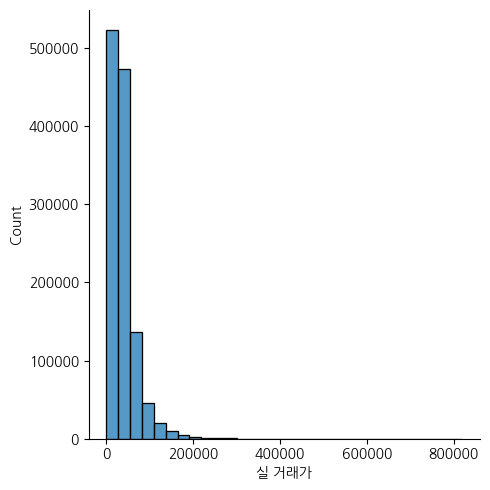

In [39]:
plt.figure()
sns.displot(train['실 거래가'], bins=30)

#### 1. 이상치 제거

In [ ]:
IQR=train['실 거래가'].quantile(0.75)-train['실 거래가'].quantile(0.25)
train1=train[train['실 거래가']<=(train['실 거래가'].quantile(0.75)+(1.5*IQR))]
train1=train1[train1['실 거래가']>=(train1['실 거래가'].quantile(0.25)-(1.5*IQR))]

train1 = train1.reset_index()
del train1['index']
train1

In [ ]:
plt.figure()
sns.displot(train1['실 거래가'], bins=30)

In [ ]:
plt.figure()
sns.displot(train['면적'], bins=30)

In [ ]:
IQR=abs(train1['면적'].quantile(0.75)-train1['면적'].quantile(0.25))
train1=train1[train1['면적']<=(train1['면적'].quantile(0.75)+(1.5*IQR))]
train1=train1[train1['면적']>=(train1['면적'].quantile(0.25)-(1.5*IQR))]

train1 = train1.reset_index()
del train1['index']
train1

In [ ]:
plt.figure()
sns.displot(train1['면적'], bins=30)

#### 2. 로그 스케일링

In [40]:
train['log_price'] = np.log1p(train['실 거래가'])
real_price = train['실 거래가'] # 원래 가격
del train['실 거래가']
train

,도시,동,아파트,면적,설립일자,거래 년/월,층수,top10,log_price
0,1,138,23,84.8200,41,0,6,0,10.532123
1,1,65,23,99.1700,12,0,10,0,9.903538
2,1,65,23,84.7400,46,0,10,0,10.558439
3,1,13,23,146.3900,42,0,19,0,11.678448
4,1,13,23,194.4300,43,0,7,0,11.695255
...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,118,7,0,9.998843
1216549,0,305,23,84.9923,51,118,11,0,10.333678
1216550,0,305,23,84.9923,51,118,13,0,10.292179
1216551,0,305,10,101.7400,47,118,11,1,10.192456


<Figure size 640x480 with 0 Axes>

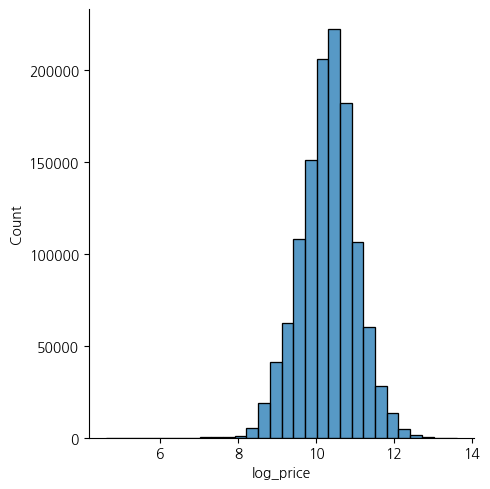

In [41]:
plt.figure()
sns.displot(train['log_price'], bins=30)

In [42]:
train['log_area'] = np.log1p(train['면적'])
test['log_area'] = np.log1p(test['면적'])
del train['면적']
del test['면적']

<Figure size 640x480 with 0 Axes>

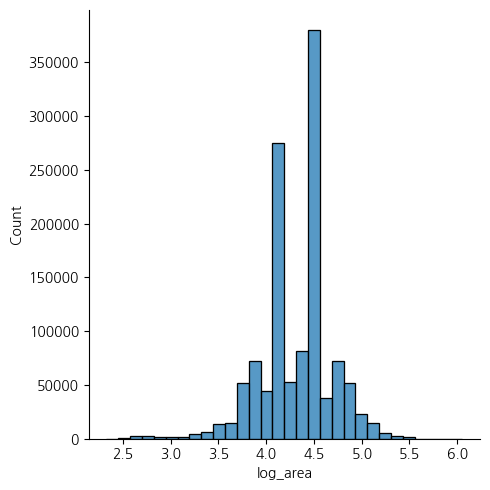

In [43]:
plt.figure()
sns.displot(train['log_area'], bins=30)

In [44]:
train

,도시,동,아파트,설립일자,거래 년/월,층수,top10,log_price,log_area
0,1,138,23,41,0,6,0,10.532123,4.452252
1,1,65,23,12,0,10,0,9.903538,4.606869
2,1,65,23,46,0,10,0,10.558439,4.451319
3,1,13,23,42,0,19,0,11.678448,4.993082
4,1,13,23,43,0,7,0,11.695255,5.275202
...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,51,118,7,0,9.998843,4.107993
1216549,0,305,23,51,118,11,0,10.333678,4.454258
1216550,0,305,23,51,118,13,0,10.292179,4.454258
1216551,0,305,10,47,118,11,1,10.192456,4.632202


## 모델링 전 타입 확인

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   도시         1216553 non-null  int64  
 1   동          1216553 non-null  object 
 2   아파트        1216553 non-null  object 
 3   설립일자       1216553 non-null  int64  
 4   거래 년/월     1216553 non-null  int64  
 5   층수         1216553 non-null  int64  
 6   top10      1216553 non-null  int64  
 7   log_price  1216553 non-null  float64
 8   log_area   1216553 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 83.5+ MB


In [46]:
train1.info()

NameError: name 'train1' is not defined

In [47]:
train['동'] = train['동'].astype('int64')
train['아파트'] = train['아파트'].astype('int64')
# train1['동'] = train1['동'].astype('int')
# train1['아파트'] = train1['아파트'].astype('int')
test['동'] = test['동'].astype('int64')
test['아파트'] = test['아파트'].astype('int64')

In [ ]:
train.info()

In [ ]:
train1.info()

# 모델링

#### 특성, 타겟 분리

In [48]:
train_X, train_y = train .drop('log_price', axis=1), train['log_price']

In [82]:
train1_X, train1_y = train1 .drop('실 거래가', axis=1), train1['실 거래가']

RMSE 점수 함수

In [78]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

cross validation 함수

In [55]:
def rmse_cv(model, train_X, train_y):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

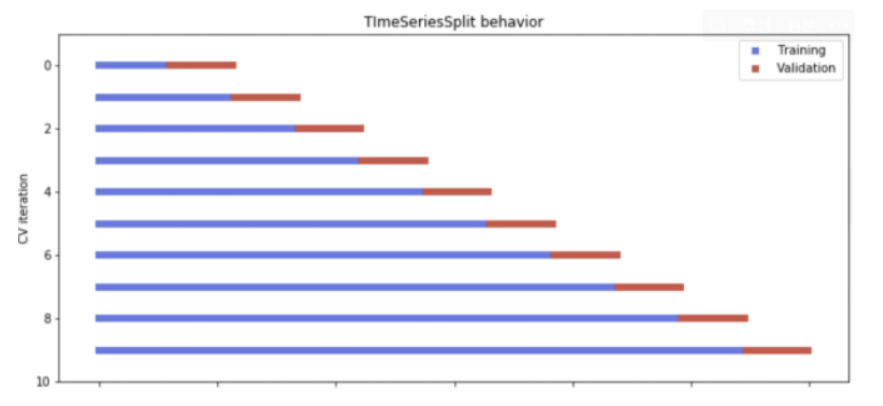

결과 출력 함수

In [56]:
def print_rmse_score(model, train_X, train_y):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model, train_X, train_y)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

#### 모델 불러오기

In [49]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

## 로그스케일링 데이터

In [86]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model, train_X, train_y)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


1 FOLDS: LinearRegression RMSLE: 0.1970
2 FOLDS: LinearRegression RMSLE: 0.2510
3 FOLDS: LinearRegression RMSLE: 0.2142
4 FOLDS: LinearRegression RMSLE: 0.3584
5 FOLDS: LinearRegression RMSLE: 0.3423
6 FOLDS: LinearRegression RMSLE: 0.3490
7 FOLDS: LinearRegression RMSLE: 0.3382
8 FOLDS: LinearRegression RMSLE: 0.2910
9 FOLDS: LinearRegression RMSLE: 0.2621
10 FOLDS: LinearRegression RMSLE: 0.2850

LinearRegression mean RMSLE: 0.2888


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s]


1 FOLDS: Ridge RMSLE: 0.1970
2 FOLDS: Ridge RMSLE: 0.2510
3 FOLDS: Ridge RMSLE: 0.2142
4 FOLDS: Ridge RMSLE: 0.3584
5 FOLDS: Ridge RMSLE: 0.3423
6 FOLDS: Ridge RMSLE: 0.3490
7 FOLDS: Ridge RMSLE: 0.3382
8 FOLDS: Ridge RMSLE: 0.2910
9 FOLDS: Ridge RMSLE: 0.2621
10 FOLDS: Ridge RMSLE: 0.2850

Ridge mean RMSLE: 0.2888


Lasso Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


1 FOLDS: Lasso RMSLE: 0.1993
2 FOLDS: Lasso RMSLE: 0.2505
3 FOLDS: Lasso RMSLE: 0.2149
4 FOLDS: Lasso RMSLE: 0.3628
5 FOLDS: Lasso RMSLE: 0.3374
6 FOLDS: Lasso RMSLE: 0.4183
7 FOLDS: Lasso RMSLE: 0.3587
8 FOLDS: Lasso RMSLE: 0.3056
9 FOLDS: Lasso RMSLE: 0.2639
10 FOLDS: Lasso RMSLE: 0.2792

Lasso mean RMSLE: 0.2990


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


1 FOLDS: ElasticNet RMSLE: 0.2063
2 FOLDS: ElasticNet RMSLE: 0.2533
3 FOLDS: ElasticNet RMSLE: 0.2177
4 FOLDS: ElasticNet RMSLE: 0.3680
5 FOLDS: ElasticNet RMSLE: 0.3344
6 FOLDS: ElasticNet RMSLE: 0.3820
7 FOLDS: ElasticNet RMSLE: 0.3596
8 FOLDS: ElasticNet RMSLE: 0.3062
9 FOLDS: ElasticNet RMSLE: 0.2677
10 FOLDS: ElasticNet RMSLE: 0.2798

ElasticNet mean RMSLE: 0.2975


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


1 FOLDS: DecisionTreeRegressor RMSLE: 0.1892
2 FOLDS: DecisionTreeRegressor RMSLE: 0.2700
3 FOLDS: DecisionTreeRegressor RMSLE: 0.2172
4 FOLDS: DecisionTreeRegressor RMSLE: 0.3592
5 FOLDS: DecisionTreeRegressor RMSLE: 0.3873
6 FOLDS: DecisionTreeRegressor RMSLE: 0.3512
7 FOLDS: DecisionTreeRegressor RMSLE: 0.3719
8 FOLDS: DecisionTreeRegressor RMSLE: 0.3128
9 FOLDS: DecisionTreeRegressor RMSLE: 0.2985
10 FOLDS: DecisionTreeRegressor RMSLE: 0.3348

DecisionTreeRegressor mean RMSLE: 0.3092


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [09:52<00:00, 59.25s/it]


1 FOLDS: RandomForestRegressor RMSLE: 0.1730
2 FOLDS: RandomForestRegressor RMSLE: 0.2497
3 FOLDS: RandomForestRegressor RMSLE: 0.2105
4 FOLDS: RandomForestRegressor RMSLE: 0.3587
5 FOLDS: RandomForestRegressor RMSLE: 0.3608
6 FOLDS: RandomForestRegressor RMSLE: 0.2969
7 FOLDS: RandomForestRegressor RMSLE: 0.3206
8 FOLDS: RandomForestRegressor RMSLE: 0.2675
9 FOLDS: RandomForestRegressor RMSLE: 0.2708
10 FOLDS: RandomForestRegressor RMSLE: 0.2517

RandomForestRegressor mean RMSLE: 0.2760


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [09:07<00:00, 54.78s/it]


1 FOLDS: XGBRegressor RMSLE: 0.1873
2 FOLDS: XGBRegressor RMSLE: 0.2346
3 FOLDS: XGBRegressor RMSLE: 0.1970
4 FOLDS: XGBRegressor RMSLE: 0.3818
5 FOLDS: XGBRegressor RMSLE: 0.3558
6 FOLDS: XGBRegressor RMSLE: 0.2820
7 FOLDS: XGBRegressor RMSLE: 0.2804
8 FOLDS: XGBRegressor RMSLE: 0.2052
9 FOLDS: XGBRegressor RMSLE: 0.2423
10 FOLDS: XGBRegressor RMSLE: 0.1109

XGBRegressor mean RMSLE: 0.2477


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]

1 FOLDS: LGBMRegressor RMSLE: 0.1821
2 FOLDS: LGBMRegressor RMSLE: 0.2260
3 FOLDS: LGBMRegressor RMSLE: 0.1879
4 FOLDS: LGBMRegressor RMSLE: 0.3589
5 FOLDS: LGBMRegressor RMSLE: 0.3205
6 FOLDS: LGBMRegressor RMSLE: 0.2635
7 FOLDS: LGBMRegressor RMSLE: 0.2631
8 FOLDS: LGBMRegressor RMSLE: 0.2088
9 FOLDS: LGBMRegressor RMSLE: 0.2396
10 FOLDS: LGBMRegressor RMSLE: 0.1454

LGBMRegressor mean RMSLE: 0.2396


## 이상치 제거 데이터

In [85]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model, train1_X, train1_y)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 10.19it/s]


1 FOLDS: LinearRegression RMSLE: 7395.7136
2 FOLDS: LinearRegression RMSLE: 7897.0678
3 FOLDS: LinearRegression RMSLE: 8636.4402
4 FOLDS: LinearRegression RMSLE: 11441.5246
5 FOLDS: LinearRegression RMSLE: 13272.7000
6 FOLDS: LinearRegression RMSLE: 7566.6620
7 FOLDS: LinearRegression RMSLE: 7711.4172
8 FOLDS: LinearRegression RMSLE: 6720.9810
9 FOLDS: LinearRegression RMSLE: 6996.9542
10 FOLDS: LinearRegression RMSLE: 9562.8727

LinearRegression mean RMSLE: 8720.2333


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 15.83it/s]


1 FOLDS: Ridge RMSLE: 7395.7107
2 FOLDS: Ridge RMSLE: 7897.0686
3 FOLDS: Ridge RMSLE: 8636.4446
4 FOLDS: Ridge RMSLE: 11441.5273
5 FOLDS: Ridge RMSLE: 13272.6994
6 FOLDS: Ridge RMSLE: 7566.6536
7 FOLDS: Ridge RMSLE: 7711.4185
8 FOLDS: Ridge RMSLE: 6720.9854
9 FOLDS: Ridge RMSLE: 6996.9555
10 FOLDS: Ridge RMSLE: 9562.8724

Ridge mean RMSLE: 8720.2336


Lasso Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


1 FOLDS: Lasso RMSLE: 7395.7110
2 FOLDS: Lasso RMSLE: 7897.0725
3 FOLDS: Lasso RMSLE: 8636.4482
4 FOLDS: Lasso RMSLE: 11441.5284
5 FOLDS: Lasso RMSLE: 13272.6998
6 FOLDS: Lasso RMSLE: 7566.6111
7 FOLDS: Lasso RMSLE: 7711.4360
8 FOLDS: Lasso RMSLE: 6720.9955
9 FOLDS: Lasso RMSLE: 6996.9588
10 FOLDS: Lasso RMSLE: 9562.8718

Lasso mean RMSLE: 8720.2333


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


1 FOLDS: ElasticNet RMSLE: 7390.3530
2 FOLDS: ElasticNet RMSLE: 7901.2259
3 FOLDS: ElasticNet RMSLE: 8667.8989
4 FOLDS: ElasticNet RMSLE: 11470.1994
5 FOLDS: ElasticNet RMSLE: 13272.7394
6 FOLDS: ElasticNet RMSLE: 7510.1230
7 FOLDS: ElasticNet RMSLE: 7743.9340
8 FOLDS: ElasticNet RMSLE: 6824.3210
9 FOLDS: ElasticNet RMSLE: 7045.7287
10 FOLDS: ElasticNet RMSLE: 9561.8629

ElasticNet mean RMSLE: 8738.8386


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


1 FOLDS: DecisionTreeRegressor RMSLE: 5950.7025
2 FOLDS: DecisionTreeRegressor RMSLE: 8327.3520
3 FOLDS: DecisionTreeRegressor RMSLE: 8652.1721
4 FOLDS: DecisionTreeRegressor RMSLE: 11317.6288
5 FOLDS: DecisionTreeRegressor RMSLE: 14022.2369
6 FOLDS: DecisionTreeRegressor RMSLE: 6702.0088
7 FOLDS: DecisionTreeRegressor RMSLE: 6963.8360
8 FOLDS: DecisionTreeRegressor RMSLE: 6210.9950
9 FOLDS: DecisionTreeRegressor RMSLE: 7608.9090
10 FOLDS: DecisionTreeRegressor RMSLE: 10972.1673

DecisionTreeRegressor mean RMSLE: 8672.8008


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [08:19<00:00, 49.95s/it]


1 FOLDS: RandomForestRegressor RMSLE: 5581.2037
2 FOLDS: RandomForestRegressor RMSLE: 7946.1981
3 FOLDS: RandomForestRegressor RMSLE: 7642.5390
4 FOLDS: RandomForestRegressor RMSLE: 11173.8178
5 FOLDS: RandomForestRegressor RMSLE: 13027.4843
6 FOLDS: RandomForestRegressor RMSLE: 5494.2976
7 FOLDS: RandomForestRegressor RMSLE: 6274.8664
8 FOLDS: RandomForestRegressor RMSLE: 5225.2541
9 FOLDS: RandomForestRegressor RMSLE: 6381.0731
10 FOLDS: RandomForestRegressor RMSLE: 8387.7705

RandomForestRegressor mean RMSLE: 7713.4505


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [08:32<00:00, 51.21s/it]


1 FOLDS: XGBRegressor RMSLE: 6334.9870
2 FOLDS: XGBRegressor RMSLE: 7645.2619
3 FOLDS: XGBRegressor RMSLE: 6961.0583
4 FOLDS: XGBRegressor RMSLE: 11271.5235
5 FOLDS: XGBRegressor RMSLE: 12523.4859
6 FOLDS: XGBRegressor RMSLE: 4852.4779
7 FOLDS: XGBRegressor RMSLE: 5050.7748
8 FOLDS: XGBRegressor RMSLE: 3994.8191
9 FOLDS: XGBRegressor RMSLE: 5331.3184
10 FOLDS: XGBRegressor RMSLE: 4709.0422

XGBRegressor mean RMSLE: 6867.4749


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]

1 FOLDS: LGBMRegressor RMSLE: 5875.0704
2 FOLDS: LGBMRegressor RMSLE: 6821.9717
3 FOLDS: LGBMRegressor RMSLE: 7004.4607
4 FOLDS: LGBMRegressor RMSLE: 9902.9103
5 FOLDS: LGBMRegressor RMSLE: 11031.7712
6 FOLDS: LGBMRegressor RMSLE: 4569.3867
7 FOLDS: LGBMRegressor RMSLE: 4800.6099
8 FOLDS: LGBMRegressor RMSLE: 4071.7380
9 FOLDS: LGBMRegressor RMSLE: 5640.6930
10 FOLDS: LGBMRegressor RMSLE: 5444.7948

LGBMRegressor mean RMSLE: 6516.3407


#### 모델별 점수 확인 및 시각화

In [87]:
result = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result

,Model,Score
0,LinearRegression,0.288831
1,Ridge,0.288831
2,Lasso,0.299037
3,ElasticNet,0.297490
4,DecisionTreeRegressor,0.309212
5,RandomForestRegressor,0.276022
6,XGBRegressor,0.247727
7,LGBMRegressor,0.239578


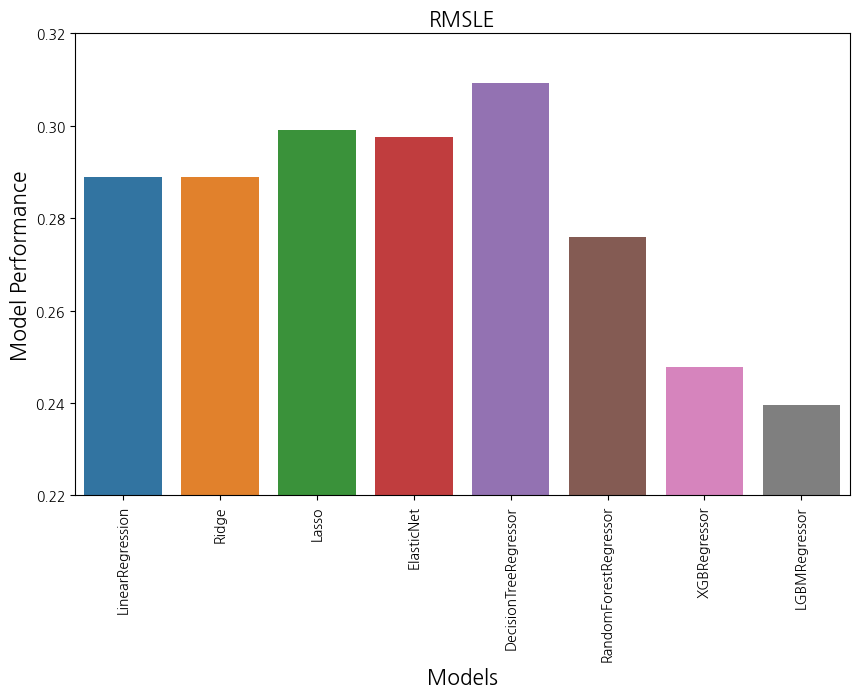

In [90]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(x=result['Model'], y=result['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

## 특성 중요도 확인

In [58]:
clf = model_lgb.fit(train_X, train_y)

<BarContainer object of 8 artists>

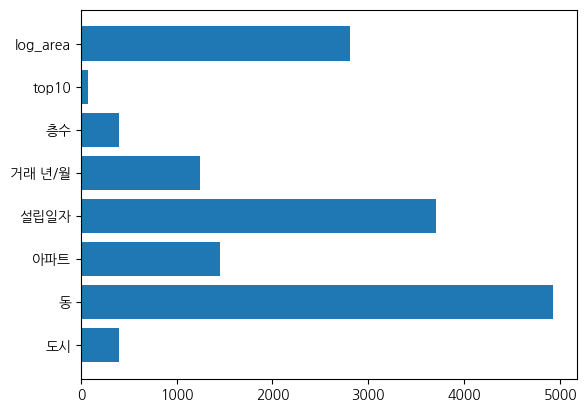

In [59]:
plt.barh(train_X.columns, clf.feature_importances_)

## 하이퍼 파라미터 튜닝

In [69]:
cut = int(len(train)*0.8)
h_train = train[:cut]
h_valid = train[cut:]

h_train_X = h_train.drop(['log_price'], axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop(['log_price'], axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 8) (973242,) (243311, 8) (243311,)


In [63]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2023-02-21 14:43:17,902] A new study created in memory with name: no-name-bb4a2498-fe51-4bae-8a81-b2e2af7afc09
[I 2023-02-21 14:43:40,433] Trial 0 finished with value: 0.7371358593423419 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.7371358593423419.
[I 2023-02-21 14:44:08,827] Trial 1 finished with value: 0.7369466723386557 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.7369466723386557.
[I 2023-02-21 14:44:10,676] Trial 2 finished with value: 0.4896851906391399 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.4896851906391399.
[I 2023-02-21 14:44:23,523] Trial 3 finished with 

[I 2023-02-21 14:51:39,663] Trial 28 finished with value: 0.2589245818719717 and parameters: {'max_depth': 7, 'learning_rate': 0.0019129532047507689, 'n_estimators': 1383, 'min_child_samples': 93, 'subsample': 0.8390572525975}. Best is trial 25 with value: 0.22171884521460258.
[I 2023-02-21 14:52:06,809] Trial 29 finished with value: 0.412216386018922 and parameters: {'max_depth': 6, 'learning_rate': 0.0004576553844928165, 'n_estimators': 1980, 'min_child_samples': 73, 'subsample': 0.7111759738045452}. Best is trial 25 with value: 0.22171884521460258.
[I 2023-02-21 14:52:41,997] Trial 30 finished with value: 0.2151307350371508 and parameters: {'max_depth': 9, 'learning_rate': 0.0033374304293500114, 'n_estimators': 2367, 'min_child_samples': 78, 'subsample': 0.9114830533669263}. Best is trial 30 with value: 0.2151307350371508.
[I 2023-02-21 14:53:18,740] Trial 31 finished with value: 0.2169983734504394 and parameters: {'max_depth': 9, 'learning_rate': 0.0028034552096531514, 'n_estimator

[I 2023-02-21 15:06:06,097] Trial 56 finished with value: 0.2101616173850606 and parameters: {'max_depth': 14, 'learning_rate': 0.009514311365430654, 'n_estimators': 2996, 'min_child_samples': 28, 'subsample': 0.6712991378912478}. Best is trial 48 with value: 0.20838460331432287.
[I 2023-02-21 15:06:39,759] Trial 57 finished with value: 0.23893287963584206 and parameters: {'max_depth': 15, 'learning_rate': 0.0013400400700965165, 'n_estimators': 2601, 'min_child_samples': 12, 'subsample': 0.7051168673752289}. Best is trial 48 with value: 0.20838460331432287.
[I 2023-02-21 15:07:05,055] Trial 58 finished with value: 0.20902273862804815 and parameters: {'max_depth': 14, 'learning_rate': 0.009320361868390189, 'n_estimators': 2511, 'min_child_samples': 21, 'subsample': 0.6503121581904318}. Best is trial 48 with value: 0.20838460331432287.
[I 2023-02-21 15:07:37,881] Trial 59 finished with value: 0.29235952384726555 and parameters: {'max_depth': 14, 'learning_rate': 0.0007826168072035589, 'n

[I 2023-02-21 15:19:14,396] Trial 84 finished with value: 0.21350725613632796 and parameters: {'max_depth': 13, 'learning_rate': 0.0070072807854575465, 'n_estimators': 1450, 'min_child_samples': 55, 'subsample': 0.7004506984899678}. Best is trial 48 with value: 0.20838460331432287.
[I 2023-02-21 15:19:50,830] Trial 85 finished with value: 0.21566740705745574 and parameters: {'max_depth': 14, 'learning_rate': 0.002785331365970946, 'n_estimators': 2861, 'min_child_samples': 49, 'subsample': 0.7278213491607545}. Best is trial 48 with value: 0.20838460331432287.
[I 2023-02-21 15:20:13,442] Trial 86 finished with value: 0.20971776337339532 and parameters: {'max_depth': 12, 'learning_rate': 0.009979372770112861, 'n_estimators': 2453, 'min_child_samples': 25, 'subsample': 0.6872493326107195}. Best is trial 48 with value: 0.20838460331432287.
[I 2023-02-21 15:20:46,502] Trial 87 finished with value: 0.21218125447512112 and parameters: {'max_depth': 14, 'learning_rate': 0.004242498091146522, 'n

## 모든 특성치 사용

In [64]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.20838460331432287,
params {'max_depth': 13, 'learning_rate': 0.009934320766298186, 'n_estimators': 2996, 'min_child_samples': 42, 'subsample': 0.7793193879552185}


In [55]:
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test)

final_lgb_pred

array([10.44213748,  9.48412573,  9.65563163, ..., 11.00014648,
       10.66989413, 10.06554204])

In [57]:
test

,도시,동,아파트,설립일자,거래 년/월,층수,top10,log_area
0,1,51,23,41,118,6,0,3.598681
1,0,417,23,16,115,6,0,4.244487
2,0,409,23,28,117,6,0,4.297829
3,1,8,23,43,114,14,0,4.723309
4,0,415,10,53,119,25,1,4.792809
...,...,...,...,...,...,...,...,...
5458,1,97,23,42,117,11,0,4.443239
5459,1,5,3,48,119,8,1,4.453533
5460,1,274,3,43,119,27,1,4.711222
5461,1,223,23,44,117,5,0,4.537320


## top10 특성 제거 (특성 중요도가 너무 낮아서)

In [103]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.20727202201866085,
params {'max_depth': 15, 'learning_rate': 0.009920869327989383, 'n_estimators': 2452, 'min_child_samples': 54, 'subsample': 0.5839686550395637}


In [122]:
test1 = test.drop(['top10'],axis = 1)
train_X, train_y = train.drop(['top10','log_price'], axis=1), train['log_price']

In [123]:
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred1 = final_lgb_model.predict(test1)

final_lgb_pred1

array([10.16779496,  9.15621557,  9.29956814, ..., 11.01510994,
       10.46950674, 10.03995678])

## 제출 파일 만들기

#### 로그 역변환

In [56]:
# 모든 특성치
final_pred_sub = np.expm1(final_lgb_pred)
final_pred_sub

array([34272.83391482, 13148.32529805, 15608.44770799, ...,
       59881.91268283, 43039.38465056, 23517.48631804])

In [58]:
s = pd.read_csv('submission.csv')
s['transaction_real_price'] = final_pred_sub
s.to_csv('submission_lgb.csv', index=False)
s

,transaction_id,transaction_real_price
0,1145756,34272.833915
1,1198704,13148.325298
2,1222384,15608.447708
3,1179897,126240.710654
4,1223091,46069.568562
...,...,...
5458,1174640,59129.948035
5459,1175575,161648.664315
5460,1157024,59881.912683
5461,1136863,43039.384651


In [124]:
# top10 특성치 제거
final_pred_sub1 = np.expm1(final_lgb_pred1)
final_pred_sub1

array([26049.57074876,  9472.13869435, 10932.29649988, ...,
       60784.70559868, 35223.83795718, 22923.39212777])

In [125]:
s1 = pd.read_csv('submission.csv')
s1['transaction_real_price'] = final_pred_sub1
s1.to_csv('submission_lgb1.csv', index=False)
s1

,transaction_id,transaction_real_price
0,1145756,26049.570749
1,1198704,9472.138694
2,1222384,10932.296500
3,1179897,117088.924394
4,1223091,45304.713998
...,...,...
5458,1174640,57356.915818
5459,1175575,155569.514404
5460,1157024,60784.705599
5461,1136863,35223.837957


# pycaret

In [54]:
from pycaret.regression import *

In [55]:
exp=setup(data=train,target='log_price',session_id=123)

,Description,Value
0,session_id,123
1,Target,log_price
2,Original Data,"(1216553, 9)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(851587, 8)"


In [55]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0553,0.0086,0.0926,0.9828,0.0085,0.0055,287.9180
et,Extra Trees Regressor,0.0562,0.0087,0.0934,0.9825,0.0086,0.0056,444.3910
dt,Decision Tree Regressor,0.0717,0.0157,0.1251,0.9685,0.0115,0.0071,0.7000
xgboost,Extreme Gradient Boosting,0.1011,0.0197,0.1402,0.9605,0.0127,0.0099,11.4540
lightgbm,Light Gradient Boosting Machine,0.1266,0.0288,0.1698,0.9420,0.0153,0.0124,0.9370
gbr,Gradient Boosting Regressor,0.1537,0.0416,0.2039,0.9164,0.0184,0.0151,14.8240
knn,K Neighbors Regressor,0.1867,0.0684,0.2614,0.8627,0.0234,0.0183,0.9710
br,Bayesian Ridge,0.2099,0.0748,0.2735,0.8497,0.0246,0.0206,0.1000
lar,Least Angle Regression,0.2099,0.0748,0.2735,0.8497,0.0246,0.0206,0.0420
ridge,Ridge Regression,0.2099,0.0748,0.2735,0.8497,0.0246,0.0206,0.0420


# stacking

In [53]:
from sklearn.ensemble import StackingRegressor

In [66]:
stack_models = [('rf',rf),('lgbm', model_lgb),('xgb',model_xgb)]

In [67]:
stack_reg = StackingRegressor(stack_models, final_estimator=rf)
stack_reg.fit(train_X, train_y)

StackingRegressor(estimators=[('rf', RandomForestRegressor()),
                              ('lgbm',
                               LGBMRegressor(max_depth=9, min_child_weight=5,
                                             n_estimators=500)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=Non...
                                            interaction_constraints=None,
                                     

In [68]:
final_stack_pred = stack_reg.predict(test)
final_stack_sub = np.expm1(final_stack_pred)
s = pd.read_csv('submission.csv')
s['transaction_real_price'] = final_stack_sub
s.to_csv('submission_stack.csv', index=False)
s

,transaction_id,transaction_real_price
0,1145756,32175.351250
1,1198704,14155.695792
2,1222384,15146.857472
3,1179897,152596.959679
4,1223091,46901.801936
...,...,...
5458,1174640,64532.417182
5459,1175575,176243.720489
5460,1157024,59731.198256
5461,1136863,41982.636901
